#### testing MSE-based instability proxy and its relationship with MCS
- check if instability (thetae_850 - thetae_500) can protrait where MCS are located 

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from datetime import datetime
from pathlib import Path

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def coordinates_processors(data):
    """
    converting longitude/latitude into lon/lat
    data: xarray.dataset coordinated horizontally in lat/lon
    """

    coord_names = []
    for coord_name in data.coords:
        coord_names.append(coord_name)

    if (set(coord_names) & set(['lon','lat'])): # if coordinates set this way...

        data2 = data.rename({'lat': 'latitude'})
        data2 = data2.rename({'lon': 'longitude'})

    else:
        data2 = data

    # check if lon from -180
    if data2.longitude[0] != 0: # -180 to 180

        lon_reset = data2.longitude
        lon_reset = lon_reset.where(lon_reset > 0, 360+lon_reset) # converting lon as 0 to 359.75
        data2.coords['longitude'] = lon_reset # converting lon as -180 to 180
        data2= data2.sortby('longitude')

    # check if latitutde is decreasing
    if (data2.latitude[1] - data2.latitude[0]) < 0:
        data2 = data2.isel(latitude=slice(None, None, -1)) # flipping latitude accoordingly

    return data2

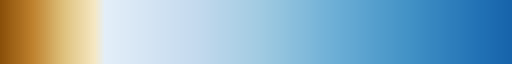

In [4]:
colors1 = plt.cm.BrBG(np.linspace(0.1, 0.4, 10))
colors2 = plt.cm.Blues(np.linspace(0.1, 0.8, 40))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [5]:
def generate_datasets(date_sel):

    year_sel = date_sel.year
    month_sel = date_sel.month

    print('Time = {}'.format(date_sel))

    year = str(year_sel)
    month = str(month_sel).zfill(2)
    day = str(date_sel.day).zfill(2)
    hour = str(date_sel.hour).zfill(2)

    # lat/lon selected
    (lat_s, lat_n) = [25, 45]
    (lon_w, lon_e) = [260, 290]

    # load MSE 
    era5_dir = Path('/neelin2020/ERA-5_mse/{}'.format(year_sel))
    data_mse = xr.open_dataset(era5_dir / 'ERA-5.mse.{}.{}.nc'.format(year_sel,str(month_sel).zfill(2)))
    dmse_850_500 = data_mse.mse_850 - data_mse.mse_sat_500 # currently 850 vs sat,500
    dmse_850_500 = coordinates_processors(dmse_850_500)
    dmse_masked = dmse_850_500.sel(time=date_sel).sel(latitude=slice(lat_s,lat_n),longitude=slice(lon_w,lon_e))
    dmse_masked = dmse_masked.where(dmse_masked >= -5)

    # load origional front masks
    mask_dir = Path('/neelin2020/mcs_flextrkr/{}'.format(year_sel))
    ft_dir = Path('/neelin2020/RGMA_feature_mask/data_product/{}/Front_expand'.format(year_sel))
    files = sorted(list(ft_dir.glob('Front_cold_ERA5feature_mask_{}_{}_6hrly.compress.nc'.format(year_sel, str(month_sel).zfill(2)))))
    data_front_c = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
    data_front_c = coordinates_processors(data_front_c)
    files = sorted(list(ft_dir.glob('Front_warm_ERA5feature_mask_{}_{}_6hrly.compress.nc'.format(year_sel, str(month_sel).zfill(2)))))
    data_front_w = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
    data_front_w = coordinates_processors(data_front_w)
    files = sorted(list(ft_dir.glob('Front_stat_ERA5feature_mask_{}_{}_6hrly.compress.nc'.format(year_sel, str(month_sel).zfill(2)))))
    data_front_s = xr.open_mfdataset(files).fronts.sel(latitude=slice(-60,60))
    data_front_s = coordinates_processors(data_front_s)

    front_c = data_front_c.sel(time=date_sel, method='nearest').sel(latitude=slice(lat_s,lat_n),longitude=slice(lon_w,lon_e))
    front_c = front_c.where(front_c == 1)
    front_w = data_front_w.sel(time=date_sel, method='nearest').sel(latitude=slice(lat_s,lat_n),longitude=slice(lon_w,lon_e))
    front_w = front_w.where(front_w == 1)
    front_s = data_front_s.sel(time=date_sel, method='nearest').sel(latitude=slice(lat_s,lat_n),longitude=slice(lon_w,lon_e))
    front_s = front_s.where(front_s == 1)

    front_joint = front_c.fillna(0) + front_w.fillna(0) + front_s.fillna(0)
    front_joint = front_joint.where(front_joint == 0, 1)
    front_joint = front_joint.where(front_joint == 1) # return back to 1, nan

    # load AR
    ar_dir = Path('/neelin2020/RGMA_feature_mask/data_product/{}/AR'.format(year_sel))
    files = sorted(list(ar_dir.glob('AR_ERA5feature_mask_{}_{}_hrly_pb.compress.nc'.format(year_sel, str(month_sel).zfill(2)))))
    data_ar = xr.open_mfdataset(files).sel(latitude=slice(-60,60))
    data_ar = coordinates_processors(data_ar)
    ar_mask = data_ar.sel(time=date_sel).ar_binary_tag.sel(latitude=slice(lat_s,lat_n),longitude=slice(lon_w,lon_e))
    ar_mask = ar_mask.where(ar_mask == 1) # 1 or nan

    # load MCS
    ds = xr.open_dataset(mask_dir / 'mcstrack_{}{}{}_{}30.nc'.format(year,month,day,hour)).isel(time=0)
    ds['lon'] = ds.lon.where(ds.lon > 0, 360 + ds.lon)
    ds = ds.sortby('lon').sel(lat=slice(lat_s,lat_n),lon=slice(lon_w,lon_e))
    precip = ds.precipitation
    precip_mask = precip.where(precip > 0)
    mcs_mask = ds.cloudtracknumber_nomergesplit
    mcs_mask = mcs_mask.where(mcs_mask > 0, 0)
    mcs_mask = mcs_mask.where(mcs_mask == 0, 1) 
    mcs_mask = mcs_mask.where(mcs_mask == 1) # 1 or NaN

    # load PFIDs 
    pfid_dir = Path('/scratch/wmtsai/GPM_feature_precip/{}'.format(year_sel))
    ds_pfid = xr.open_dataset(pfid_dir / 'GPM-IMERG_feature_precip_{}_{}.nc'.format(year, month))
    pfid = ds_pfid.sel(time=date_sel).precip_id.sel(latitude=slice(lat_s,lat_n),longitude=slice(lon_w,lon_e))

    return (dmse_masked, precip_mask, front_joint, mcs_mask, ar_mask, pfid)

In [37]:
%%time
date_selected = datetime(2019,6,25,0)
year = str(date_selected.year)
month = str(date_selected.month).zfill(2)
day = str(date_selected.day).zfill(2)
hour = str(date_selected.hour).zfill(2)
(dmse_masked, precip_mask, front_joint, mcs_mask, ar_mask, pfid) = generate_datasets(date_selected)

Time = 2019-06-25 00:00:00
CPU times: user 557 ms, sys: 25.8 s, total: 26.3 s
Wall time: 26.6 s


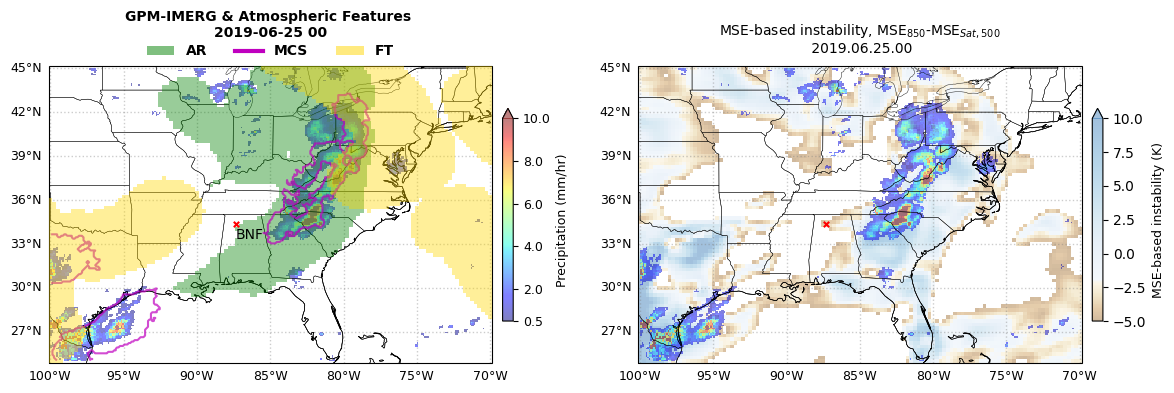

In [39]:
# plotting (a) feature maks and precipitation (b) MSE_850 - MSE_sat,500
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),subplot_kw={'projection': ccrs.PlateCarree()})

ax1.coastlines(resolution='50m', color='k',linewidth=0.5)
ax1.add_feature(cfeat.LAND,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3) 
ax1.add_feature(cfeat.BORDERS,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)
ax1.add_feature(cfeat.STATES,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)

# add precip
precip_gt1 = precip_mask.where(precip_mask > 0.5)
cp = ax1.pcolormesh(precip_mask.lon, precip_mask.lat, precip_gt1, vmin=0.5, vmax=10, zorder=2, cmap='jet', alpha=0.5
        , transform=ccrs.PlateCarree())
cbar = plt.colorbar(cp, ax=ax1, shrink=0.6, pad=0.02, extend='max')
cbar.set_ticks([0.5,2,4,6,8,10])
cbar.ax.tick_params(labelsize=9) 
cbar.set_label('Precipitation (mm/hr)',fontsize=9)
# add AR
ax1.pcolormesh(ar_mask.longitude, ar_mask.latitude, ar_mask, cmap=ListedColormap(['g']), alpha=0.4,
                transform=ccrs.PlateCarree(), zorder=3) # all fronts
# add MCS features on top of the MSE map
ax1.contour(mcs_mask.lon, mcs_mask.lat, mcs_mask.fillna(0), levels=[0.9,1.1], zorder=3, colors=['m'], alpha=0.7
        , transform=ccrs.PlateCarree())
# add fronts, all types but same color
ax1.pcolormesh(front_joint.longitude, front_joint.latitude, front_joint, cmap=ListedColormap(['gold']), alpha=0.4,
                transform=ccrs.PlateCarree(), zorder=3) # all fronts

# add BNF ARM site
lat_BNF = 34.34
lon_BNF = 360-87.33 
ax1.scatter(lon_BNF, lat_BNF,  s=15, marker='x', color='r', transform=ccrs.PlateCarree(), zorder=3)
ax1.text(x=lon_BNF, y=lat_BNF-1, s='BNF', fontsize=10, transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':9}
gl.ylabel_style = {'size':9}

# add feature mask legend
legend_elements = [Patch(facecolor='green', edgecolor=None, alpha=0.5,
                        label='AR'),
                Line2D([1], [1], color='m', lw=3, label='MCS'),
                Patch(facecolor='gold', edgecolor=None, alpha=0.5,
                        label='FT')]

ax1.legend(handles=legend_elements, loc='center', ncols=3, bbox_to_anchor=(0.5, 1.05)
        ,frameon=False, prop={'weight':'bold'})
ax1.set_title('GPM-IMERG & Atmospheric Features \n' + '{}'.format(str(date_selected)[:13])
                , fontsize=10, y=1.07, fontweight='bold')

################################ Panel b for MSE-based instability + precip ##########
ax2.coastlines(resolution='50m', color='k',linewidth=0.5)
ax2.add_feature(cfeat.LAND,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3) 
ax2.add_feature(cfeat.BORDERS,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)
ax2.add_feature(cfeat.STATES,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)

ax2.pcolormesh(precip_mask.lon, precip_mask.lat, precip_gt1, vmin=0, vmax=10, zorder=2, cmap='jet', alpha=0.5
        , transform=ccrs.PlateCarree())

# mse instability
cp = ax2.pcolormesh(dmse_masked.longitude, dmse_masked.latitude, dmse_masked, vmin=-5,vmax=10, zorder=1, alpha=0.4
                , cmap=mixedmap, transform=ccrs.PlateCarree())
cbar = plt.colorbar(cp, ax=ax2, shrink=0.6, pad=0.02, extend='max')
cbar.set_label('MSE-based instability (K)',fontsize=9)
cp.cmap.set_under('w')

# add BNF ARM site
lat_BNF = 34.34
lon_BNF = 360-87.33 
ax2.scatter(lon_BNF, lat_BNF,  s=15, marker='x', color='r', transform=ccrs.PlateCarree(), zorder=3)

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':9}
gl.ylabel_style = {'size':9}

ax2.set_title(r'MSE-based instability, MSE$_{850}$-MSE$_{Sat,500}$'+ '\n {}.{}.{}.{}'.format(year,month,day,hour)
,fontsize=10)

plt.tight_layout()
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig_MCS_MSEinstability/Schiro_DOEproposal/Fig3_feature_precip_summertime_2019062500Z.pdf',
          dpi=800, bbox_inches='tight', transparent=False)

#### winter time example

In [18]:
%%time
date_selected = datetime(2019,12,1,0)
year = str(date_selected.year)
month = str(date_selected.month).zfill(2)
day = str(date_selected.day).zfill(2)
hour = str(date_selected.hour).zfill(2)
(dmse_masked, precip_mask, front_joint, mcs_mask, ar_mask, pfid) = generate_datasets(date_selected)

Time = 2019-12-01 00:00:00
CPU times: user 570 ms, sys: 27.4 s, total: 27.9 s
Wall time: 28.3 s


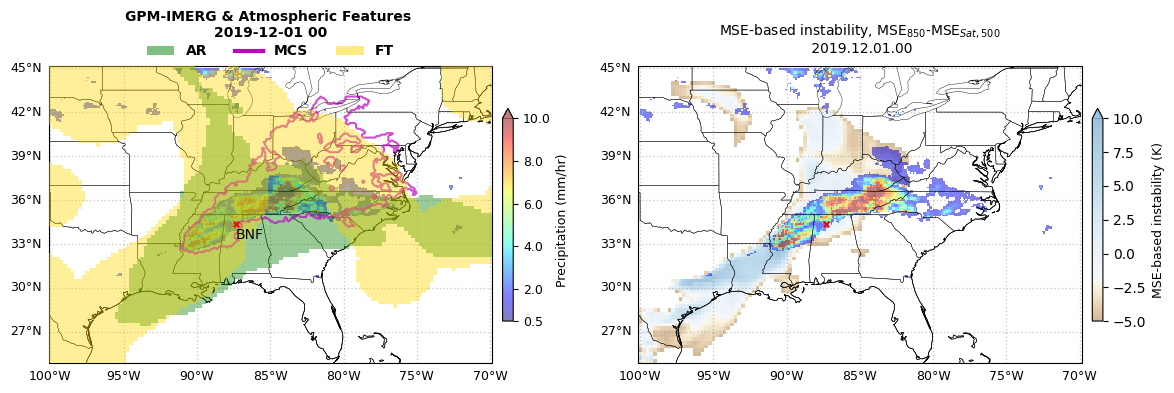

In [19]:
# plotting (a) feature maks and precipitation (b) MSE_850 - MSE_sat,500
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),subplot_kw={'projection': ccrs.PlateCarree()})

ax1.coastlines(resolution='50m', color='k',linewidth=0.5)
ax1.add_feature(cfeat.LAND,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3) 
ax1.add_feature(cfeat.BORDERS,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)
ax1.add_feature(cfeat.STATES,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)

# add precip
precip_gt1 = precip_mask.where(precip_mask > 0.5)
cp = ax1.pcolormesh(precip_mask.lon, precip_mask.lat, precip_gt1, vmin=0.5, vmax=10, zorder=2, cmap='jet', alpha=0.5
        , transform=ccrs.PlateCarree())
cbar = plt.colorbar(cp, ax=ax1, shrink=0.6, pad=0.02, extend='max')
cbar.set_ticks([0.5,2,4,6,8,10])
cbar.ax.tick_params(labelsize=9) 
cbar.set_label('Precipitation (mm/hr)',fontsize=9)
# add AR
ax1.pcolormesh(ar_mask.longitude, ar_mask.latitude, ar_mask, cmap=ListedColormap(['g']), alpha=0.4,
                transform=ccrs.PlateCarree(), zorder=3) # all fronts
# add MCS features on top of the MSE map
ax1.contour(mcs_mask.lon, mcs_mask.lat, mcs_mask.fillna(0), levels=[0.9,1.1], zorder=3, colors=['m'], alpha=0.7
        , transform=ccrs.PlateCarree())
# add fronts, all types but same color
ax1.pcolormesh(front_joint.longitude, front_joint.latitude, front_joint, cmap=ListedColormap(['gold']), alpha=0.4,
                transform=ccrs.PlateCarree(), zorder=3) # all fronts

# add BNF ARM site
lat_BNF = 34.34
lon_BNF = 360-87.33 
ax1.scatter(lon_BNF, lat_BNF,  s=15, marker='x', color='r', transform=ccrs.PlateCarree(), zorder=3)
ax1.text(x=lon_BNF, y=lat_BNF-1, s='BNF', fontsize=10, transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':9}
gl.ylabel_style = {'size':9}

#ax1.set_title('Atmospheric features, AR (green), Front (yellow), MCS (magenta) \n {}.{}.{}.{}'.format(year,month,day,hour)
#,fontsize=10)

# add feature mask legend
legend_elements = [Patch(facecolor='green', edgecolor=None, alpha=0.5,
                        label='AR'),
                Line2D([1], [1], color='m', lw=3, label='MCS'),
                Patch(facecolor='gold', edgecolor=None, alpha=0.5,
                        label='FT')]

ax1.legend(handles=legend_elements, loc='center', ncols=3, bbox_to_anchor=(0.5, 1.05)
        ,frameon=False, prop={'weight':'bold'})
ax1.set_title('GPM-IMERG & Atmospheric Features \n' + '{}'.format(str(date_selected)[:13])
                , fontsize=10, y=1.07, fontweight='bold')

################################ Panel b for MSE-based instability + precip ##########
ax2.coastlines(resolution='50m', color='k',linewidth=0.5)
ax2.add_feature(cfeat.LAND,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3) 
ax2.add_feature(cfeat.BORDERS,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)
ax2.add_feature(cfeat.STATES,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)

ax2.pcolormesh(precip_mask.lon, precip_mask.lat, precip_gt1, vmin=0, vmax=10, zorder=2, cmap='jet', alpha=0.5
        , transform=ccrs.PlateCarree())

# mse instability
cp = ax2.pcolormesh(dmse_masked.longitude, dmse_masked.latitude, dmse_masked, vmin=-5,vmax=10, zorder=1, alpha=0.4
                , cmap=mixedmap, transform=ccrs.PlateCarree())
cbar = plt.colorbar(cp, ax=ax2, shrink=0.6, pad=0.02, extend='max')
cbar.set_label('MSE-based instability (K)',fontsize=9)
cp.cmap.set_under('w')

# add BNF ARM site
lat_BNF = 34.34
lon_BNF = 360-87.33 
ax2.scatter(lon_BNF, lat_BNF,  s=15, marker='x', color='r', transform=ccrs.PlateCarree(), zorder=3)

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':9}
gl.ylabel_style = {'size':9}

ax2.set_title(r'MSE-based instability, MSE$_{850}$-MSE$_{Sat,500}$'+ '\n {}.{}.{}.{}'.format(year,month,day,hour)
,fontsize=10)

plt.tight_layout()
plt.show()

#fig.savefig('/scratch/wmtsai/temp_mcs/fig_MCS_MSEinstability/Schiro_DOEproposal/Fig3_feature_precip_wintertime_2019121700Z.pdf',
#          bbox_inches='tight', transparent=False)

In [ ]:
cmap_label = plt.get_cmap('tab20b', 20)
FID_colors = cmap_label(np.linspace(0, 1, 20))

FID_colors[0, :] = np.array([0, 0, 0.5, 1]) # AR
FID_colors[1, :] = np.array([180/255, 220/255, 220/255, 1]) # Front
FID_colors[2, :] = np.array([255/255, 255/255, 0, 1]) # MCS
FID_colors[3, :] = np.array([1, 0, 0, 1]) # LPS

FID_colors[4, :] = (FID_colors[0, :] + FID_colors[1, :])/2 # AF
FID_colors[5, :] = (FID_colors[0, :] + FID_colors[2, :])/2 # AM
FID_colors[6, :] = (FID_colors[0, :] + FID_colors[3, :])/2  # AL
FID_colors[7, :] = (FID_colors[1, :] + FID_colors[2, :])/2  # FM
FID_colors[8, :] = (FID_colors[1, :] + FID_colors[3, :])/2  # FL
FID_colors[9, :] = (FID_colors[2, :] + FID_colors[3, :])/2  # ML

FID_colors[10, :] = (FID_colors[0, :] + FID_colors[1, :] + FID_colors[2, :])/3 # AFM
FID_colors[11, :] = (FID_colors[0, :] + FID_colors[1, :] + FID_colors[3, :])/3 # AFL
FID_colors[12, :] = (FID_colors[0, :] + FID_colors[2, :] + FID_colors[3, :])/3  # AML
FID_colors[13, :] = (FID_colors[1, :] + FID_colors[2, :] + FID_colors[3, :])/3  # FML
FID_colors[14, :] = (FID_colors[0, :] + FID_colors[1, :] + FID_colors[2, :] + FID_colors[3, :])/4  # All

# unexplained
white = np.array([255/255, 255/255, 255/255, 1])
FID_colors[15, :] = white
# Deep convection (BT < 241 K, 0.5mm/hr)
purple = np.array([153/255, 0, 153/255 ,0.7])
FID_colors[16, :] = purple
# Congestus (310K < BT < 241 K, 0.5mm/hr)
magenta = np.array([255/255, 204/255, 255/255, 0.6])
FID_colors[17, :] = magenta
# anvil clouds (BT < 241 K)
FID_colors[18, :] = np.array([178/255, 102/255, 255/255, 0.6])
# drizzle (< 0.5 mm/hr)
FID_colors[19, :] = np.array([210/255, 210/255, 210/255, 1])

FID_cmp = ListedColormap(FID_colors)
FID_cmp

In [ ]:
# plot the PFID 

PFID_catalog = {'AR':1, 'FT':2, 'MCS': 3, 'LPS': 4,
                'AR-FT': 5, 'AR-MCS': 6, 'AR-LPS': 7,
                'FT-MCS': 8,' FT-LPS': 9, 'MCS-LPS': 10,
                'AR-FT-MCS': 11, 'AR-FT-LPS': 12, 'AR-MCS-LPS': 13,
                'FT-MCS-LPS': 14, 'AR-FT-MCS-LPS': 15,
                'Unexp': 16,
                'DC': 17, 'ND': 18, 'ST': 19, 'DZ': 20}

# plotting (a) feature maks and precipitation (b) MSE_850 - MSE_sat,500
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),subplot_kw={'projection': ccrs.PlateCarree()})

ax1.coastlines(resolution='50m', color='k',linewidth=0.5)
ax1.add_feature(cfeat.LAND,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3) 
ax1.add_feature(cfeat.BORDERS,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)
ax1.add_feature(cfeat.STATES,zorder=3,edgecolor='k',facecolor='none',linewidth=0.3)

# add AR
ax1.contour(ar_mask.longitude, ar_mask.latitude, ar_mask, levels=[0.9,1.1], zorder=3, colors=['g'], alpha=0.7
        , transform=ccrs.PlateCarree())
# add MCS features on top of the MSE map
ax1.contour(mcs_mask.lon, mcs_mask.lat, mcs_mask.fillna(0), levels=[0.9,1.1], zorder=3, colors=['m'], alpha=0.7
        , transform=ccrs.PlateCarree())
# add fronts, all types but same color
ax1.pcolormesh(front_c.longitude, front_c.latitude, front_c, cmap=ListedColormap(['y']), alpha=0.2,
                transform=ccrs.PlateCarree(), zorder=3) # cold front
ax1.pcolormesh(front_w.longitude, front_w.latitude, front_w, cmap=ListedColormap(['y']), alpha=0.2,
                transform=ccrs.PlateCarree(), zorder=3) # cold front
ax1.pcolormesh(front_s.longitude, front_s.latitude, front_s, cmap=ListedColormap(['y']), alpha=0.2,
                transform=ccrs.PlateCarree(), zorder=3) # cold front   

pfid_mask = pfid.where(pfid > 0) # remove non-precip grids
cmap_norm = FID_cmp
# add precip
levels = np.array([0,1,2,3,5,6,8,17,18,19,20])
levels_adj = levels + 0.5
label_loc = np.zeros(len(levels)-1)
for n in range(len(levels_adj)-1):
    label_loc[n] = 1/2*(levels_adj[n] + levels_adj[n+1])

cp = ax1.pcolormesh(pfid_mask.longitude, pfid_mask.latitude, pfid_mask, zorder=2, cmap=FID_cmp, 
                    norm = mpl.colors.BoundaryNorm(levels_adj, ncolors=cmap_norm.N), alpha=0.7
        , transform=ccrs.PlateCarree())
cbar = plt.colorbar(cp, ax=ax1, shrink=0.75, pad=0.02)
cbar.set_ticks(label_loc)
cbar.set_ticklabels(['AR','FT','MCS','AR-FT','AR-MCS','FT-MCS','DC','ND','ST','DZ'])
cbar.ax.minorticks_off()

cbar.ax.tick_params(labelsize=9) 
#cbar.set_label('Precipitation (mm/hr)',fontsize=9)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':9}
gl.ylabel_style = {'size':9}

# add BNF ARM site
lat_BNF = 34.34
lon_BNF = 360-87.33 
ax1.scatter(lon_BNF, lat_BNF,  s=15, marker='x', color='r', transform=ccrs.PlateCarree(), zorder=3)
ax1.text(x=lon_BNF, y=lat_BNF-1, s='BNF', fontsize=10, transform=ccrs.PlateCarree())

ax1.set_title('Precipitation from feature co-occurrences \n {}.{}.{}.{}'.format(year,month,day,hour)
,fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
cbar.get_ticks()

In [ ]:
### 1. buoyancy-precip 1-D: all grids, MCS grids, non-MCS grids 

### get B-P data of all grids ####
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/buoy_precip_1D_multiregions/SEUS')
files = sorted(list(out_dir.glob('buoy_precipitation_SEUS*')))
for n,file in enumerate(files):
    data_all = xr.open_dataset(file)
    if n == 0:
        samples = data_all.samples
        prec_sum = data_all.prec_gpm_sum
    else:
        samples += data_all.samples
        prec_sum += data_all.prec_gpm_sum
    
cond_prec = prec_sum/samples
# masking out under-sampled values
cond_prec = cond_prec.where(samples > 100)

# ###### plotting #######
fig,(ax,ax1) = plt.subplots(1,2,figsize=(7,3)) 

ax2 = ax.twinx() # for PDF
for gtype,color in zip(['non_MCS'], ['k']):

    ax.plot(data_all.BL_bins, cond_prec.sel(grid_type=gtype), 'o', color=color, markeredgecolor='none', ls='None', ms=5, 
        alpha=0.5)
    ax2.plot(data_all.BL_bins, samples.sel(grid_type=gtype)/samples.sel(grid_type=gtype).sum(), '-', color=color, alpha=0.6)
    ax2.set_ylim([0,0.05])
    ax2.tick_params(labelsize=9)

for gtype,color in zip(['MCS'], ['r']):

    ax.plot(data_all.BL_bins, cond_prec.sel(grid_type=gtype), '^', color=color, markeredgecolor='none', ls='None', ms=6, 
        alpha=0.5)
    ax2.plot(data_all.BL_bins, samples.sel(grid_type=gtype)/samples.sel(grid_type=gtype).sum(), '-', color=color, alpha=0.6)
    ax2.set_ylim([0,0.05])
    ax2.tick_params(labelsize=9)

ax.set_ylabel('Precipitation rate (mm hr$^{-1}$)',fontsize=9)
ax.set_xlabel('Buoyancy measure, B$_{L}$ (K)',fontsize=9)
ax.tick_params(labelsize=9)
ax.set_ylim([0,10])
ax.set_xlim([-20,5])
ax.grid(lw=0.2,ls=':',color='grey')
ax.legend(['Non-MCS','MCS'],
           bbox_to_anchor=(0.00, 0.35, 0.5, 0.5),fontsize=10, frameon=False)
ax.text(x=-18, y=8.7, s='Southeastern U.S.', fontsize=10, fontweight='bold',
        bbox=dict(facecolor='w', edgecolor='none', pad=2.5, lw=0.5))
ax.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)

# ###### plotting b. BL contribution from MCS#######
fraction_mcs = samples.sel(grid_type='MCS') /samples.sum('grid_type')
fraction_mcs = fraction_mcs.where(samples.sum('grid_type') >200)

ax1.plot(fraction_mcs.BL_bins, 100*fraction_mcs, 'o', color='k', markeredgecolor='none', ls='None', ms=5, 
        alpha=0.8)
    
ax1.set_ylabel('MCS contribution (%)',fontsize=9)
ax1.set_xlabel('Buoyancy measure, B$_{L}$ (K)',fontsize=9)
ax1.tick_params(labelsize=9)
ax1.set_ylim([0,100])
ax1.set_xlim([-20,5])
ax1.grid(lw=0.2,ls=':',color='grey')
ax1.spines[['right', 'top']].set_visible(False)

#add a inset of SEUS geolocation map 
axins = inset_axes(ax1, width="65%", height="65%", loc='lower left',
                   bbox_to_anchor=(0.05, 0.3, 0.8, 1),
                   bbox_transform=ax1.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes,
                   axes_kwargs=dict(projection=ccrs.PlateCarree()))
axins.stock_img()
axins.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
axins.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
axins.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 
inset_extent = [-82, -90, 28.5, 36.5]
axins.set_extent(inset_extent)

plt.tight_layout()
#plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/ARM_BuoyPrec_SEUS.pdf',
       bbox_inches='tight', transparent=False)

In [ ]:
data_all